In [217]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from bs4 import BeautifulSoup as bs
import requests
import re
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix, balanced_accuracy_score, roc_curve, auc
import xgboost as xgb
import imblearn

%matplotlib inline

In [2]:
r = requests.get('https://bestreamer.com/gaming/all-legendary-pokemon-by-generation/#ib-toc-anchor-67')
soup = bs(r.content)

In [3]:
legendary_ids = []
pattern = re.compile(r'dex Number: \d{3}')
ul = soup.find_all('ul', {'class': 'has-small-font-size'})
for i in range(len(ul)):
    if 'dex Number:' in ul[i].text:
        legendary_ids.append(pattern.findall(ul[i].text)[0])
    else:
        continue
        
for i in range(len(legendary_ids)):
    legendary_ids[i] = int(legendary_ids[i].split(' ')[2])
    
legendary_ids = legendary_ids[:legendary_ids.index(809)+1]

In [4]:
df = pd.read_csv('all_pokemon_data.csv')
df.set_index('id', inplace = True)

In [5]:
df.head(10)

,name,typing,classification,height_m,weight_kg,capture_rate,abilities,hp,atk,def,...,taken_ground,taken_flying,taken_psychic,taken_bug,taken_rock,taken_ghost,taken_dragon,taken_dark,taken_steel,taken_fairy
id,,,,,,,,,,,,,,,,,,,,,
1,Bulbasaur,"['Grass', 'Poison']",Seed Pokémon,0.7,6.9,45,['Overgrow'],45,49,49,...,1.0,2.0,2.0,1.00,1.0,1.0,1.0,1.0,1.0,0.5
2,Ivysaur,"['Grass', 'Poison']",Seed Pokémon,1.0,13.0,45,['Overgrow'],60,62,63,...,1.0,2.0,2.0,1.00,1.0,1.0,1.0,1.0,1.0,0.5
3,Venusaur,"['Grass', 'Poison']",Seed Pokémon,2.0,100.0,45,['Overgrow'],80,82,83,...,1.0,2.0,2.0,1.00,1.0,1.0,1.0,1.0,1.0,0.5
4,Charmander,['Fire'],Lizard Pokémon,0.6,8.5,45,['Blaze'],39,52,43,...,2.0,1.0,1.0,0.50,2.0,1.0,1.0,1.0,0.5,0.5
5,Charmeleon,['Fire'],Flame Pokémon,1.1,19.0,45,['Blaze'],58,64,58,...,2.0,1.0,1.0,0.50,2.0,1.0,1.0,1.0,0.5,0.5
6,Charizard,"['Fire', 'Flying']",Flame Pokémon,1.7,90.5,45,['Blaze'],78,84,78,...,0.0,1.0,1.0,0.25,4.0,1.0,1.0,1.0,0.5,0.5
7,Squirtle,['Water'],Tiny Turtle Pokémon,0.5,9.0,45,['Torrent'],44,48,65,...,1.0,1.0,1.0,1.00,1.0,1.0,1.0,1.0,0.5,1.0
8,Wartortle,['Water'],Turtle Pokémon,1.0,22.5,45,['Torrent'],59,63,80,...,1.0,1.0,1.0,1.00,1.0,1.0,1.0,1.0,0.5,1.0
9,Blastoise,['Water'],Shellfish Pokémon,1.6,85.5,45,['Torrent'],79,83,100,...,1.0,1.0,1.0,1.00,1.0,1.0,1.0,1.0,0.5,1.0


## Data Cleaning

In [6]:
df['total_stats'] = df['hp'] + df['atk'] + df['def'] + df['sp_atk'] + df['sp_def'] + df['spd']

In [7]:
df['typing']

id
1      ['Grass', 'Poison']
2      ['Grass', 'Poison']
3      ['Grass', 'Poison']
4                 ['Fire']
5                 ['Fire']
              ...         
805      ['Rock', 'Steel']
806      ['Fire', 'Ghost']
807           ['Electric']
808              ['Steel']
809              ['Steel']
Name: typing, Length: 809, dtype: object

In [8]:
df.loc[1, 'typing'].strip('[]').split(',')[0].replace('\'', ' ').strip()

'Grass'

In [9]:
df['type_1'] = 0
for row in range(1, len(df)+1):
    df.loc[row, 'type_1'] = df.loc[row, 'typing'].strip('[]').split(',')[0].replace('\'', ' ').strip()

In [10]:
df['type_2'] = np.NaN
for row in range(1, len(df)+1):
    if len(df.loc[row, 'typing'].strip('[]').split(',')) == 2:
        df.loc[row, 'type_2'] = df.loc[row, 'typing'].strip('[]').split(',')[1].replace('\'', ' ').strip()
    else:
        continue

In [11]:
cols = ['name',
 'classification',
 'type_1',
 'type_2',
 'height_m',
 'weight_kg',
 'capture_rate',
 'abilities',
 'hp',
 'atk',
 'def',
 'sp_atk',
 'sp_def',
 'spd',
 'total_stats',
 'taken_normal',
 'taken_fire',
 'taken_water',
 'taken_electric',
 'taken_grass',
 'taken_ice',
 'taken_fighting',
 'taken_poison',
 'taken_ground',
 'taken_flying',
 'taken_psychic',
 'taken_bug',
 'taken_rock',
 'taken_ghost',
 'taken_dragon',
 'taken_dark',
 'taken_steel',
 'taken_fairy']

df = df[cols]

In [12]:
for row in range(1, len(df)+1):
    df.loc[row, 'abilities'] = df.loc[row, 'abilities'].strip('[]').replace('\'', ' ').strip()

In [13]:
df['is_legendary'] = 0

for entry in legendary_ids:
    df.loc[entry, 'is_legendary'] = 1

In [45]:
df.to_excel('all_pokemon_data_modified.xlsx')
df.to_csv('all_pokemon_data_modified.csv')

# Exploratory Data Analysis

In [37]:
df.head(5)

,name,classification,type_1,type_2,height_m,weight_kg,capture_rate,abilities,hp,atk,...,taken_psychic,taken_bug,taken_rock,taken_ghost,taken_dragon,taken_dark,taken_steel,taken_fairy,is_legendary,count
id,,,,,,,,,,,,,,,,,,,,,
1,Bulbasaur,Seed Pokémon,Grass,Poison,0.7,6.9,45,Overgrow,45,49,...,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5,0,1
2,Ivysaur,Seed Pokémon,Grass,Poison,1.0,13.0,45,Overgrow,60,62,...,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5,0,1
3,Venusaur,Seed Pokémon,Grass,Poison,2.0,100.0,45,Overgrow,80,82,...,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5,0,1
4,Charmander,Lizard Pokémon,Fire,NaN,0.6,8.5,45,Blaze,39,52,...,1.0,0.5,2.0,1.0,1.0,1.0,0.5,0.5,0,1
5,Charmeleon,Flame Pokémon,Fire,NaN,1.1,19.0,45,Blaze,58,64,...,1.0,0.5,2.0,1.0,1.0,1.0,0.5,0.5,0,1


In [36]:
df.describe()

,height_m,weight_kg,capture_rate,hp,atk,def,sp_atk,sp_def,spd,total_stats,...,taken_psychic,taken_bug,taken_rock,taken_ghost,taken_dragon,taken_dark,taken_steel,taken_fairy,is_legendary,count
count,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,...,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.0
mean,1.162917,62.617182,97.729295,68.935723,76.155748,71.805933,69.494438,69.964153,65.739184,422.095179,...,1.007108,0.991347,1.246601,0.987639,0.968480,1.057787,0.981150,1.066440,0.100124,1.0
std,1.081246,114.381499,76.459542,26.589394,29.604246,29.799921,29.416946,27.286887,27.736784,111.438711,...,0.497390,0.596700,0.696351,0.557772,0.354334,0.437259,0.498792,0.522532,0.300350,0.0
min,0.100000,0.100000,3.000000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000,175.000000,...,0.000000,0.250000,0.250000,0.000000,0.000000,0.250000,0.250000,0.250000,0.000000,1.0
25%,0.600000,9.000000,45.000000,50.000000,55.000000,50.000000,45.000000,50.000000,45.000000,320.000000,...,1.000000,0.500000,1.000000,1.000000,1.000000,1.000000,0.500000,1.000000,0.000000,1.0
50%,1.000000,27.000000,60.000000,65.000000,75.000000,67.000000,65.000000,65.000000,65.000000,431.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.0
75%,1.500000,63.000000,155.000000,80.000000,95.000000,89.000000,90.000000,85.000000,85.000000,500.000000,...,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.0
max,14.500000,999.900000,255.000000,255.000000,181.000000,230.000000,173.000000,230.000000,160.000000,720.000000,...,4.000000,4.000000,4.000000,4.000000,2.000000,4.000000,4.000000,4.000000,1.000000,1.0


In [156]:
fig = go.Figure()
fig.add_trace(go.Box(y = df['hp'], name = 'HP', boxmean = True))
fig.add_trace(go.Box(y = df['atk'], name = 'Attack',boxmean = True))
fig.add_trace(go.Box(y = df['def'], name = 'Defense', boxmean = True))
fig.add_trace(go.Box(y = df['sp_atk'], name = 'Sp. Attack', boxmean = True))
fig.add_trace(go.Box(y = df['sp_def'], name = 'Sp. Defense', boxmean = True))
fig.add_trace(go.Box(y = df['spd'], name = 'Speed', boxmean = True))
fig.update_layout(title = 'Distribution by Stat for all Pokemon',
                  yaxis = dict(autorange = True, showgrid = True, dtick = 20),
                  paper_bgcolor = 'rgb(255, 255, 255)',
                  plot_bgcolor = 'rgb(255, 255, 255)',
                  showlegend = False)
fig.show()

## Univariate Analysis

In [26]:
df['count'] = 1
print(df.groupby('type_1').count()['count'].sort_values(ascending = False))
print(df.groupby('type_2').count()['count'].sort_values(ascending = False))

type_1
Water       114
Normal      105
Grass        78
Bug          72
Psychic      53
Fire         53
Rock         46
Electric     40
Poison       34
Ground       32
Fighting     29
Dark         29
Dragon       27
Ghost        27
Steel        26
Ice          23
Fairy        18
Flying        3
Name: count, dtype: int64
type_2
Flying      94
Poison      32
Fairy       29
Ground      29
Psychic     27
Fighting    25
Steel       23
Dark        19
Dragon      18
Grass       18
Water       17
Ghost       14
Rock        14
Ice         12
Fire        11
Electric     8
Bug          5
Normal       4
Name: count, dtype: int64


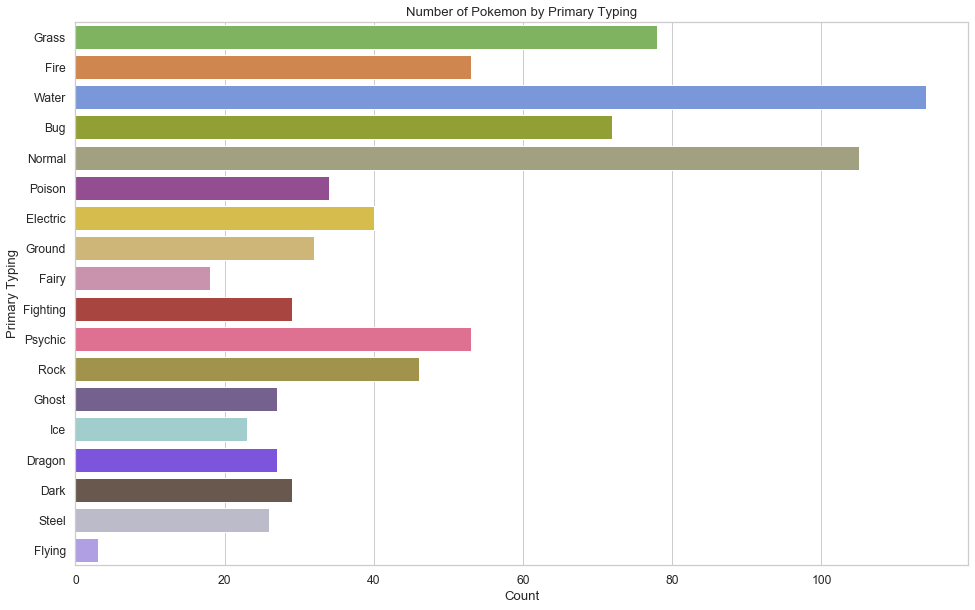

In [321]:
fig, ax = plt.subplots(1,1, figsize = (16,10))
with sns.color_palette(['#7AC74C', '#EE8130','#6390F0',
                        '#A6B91A','#A8A77A','#A33EA1',
                        '#F7D02C','#E2BF65','#D685AD',
                        '#C22E28','#F95587','#B6A136',
                        '#735797','#96D9D6','#6F35FC',
                        '#705746','#B7B7CE','#A98FF3'], desat = 0.9):
    sns.countplot(data = df, y = 'type_1', orient = 'h')
    ax.set(xlabel = 'Count', ylabel = 'Primary Typing', title = 'Number of Pokemon by Primary Typing')

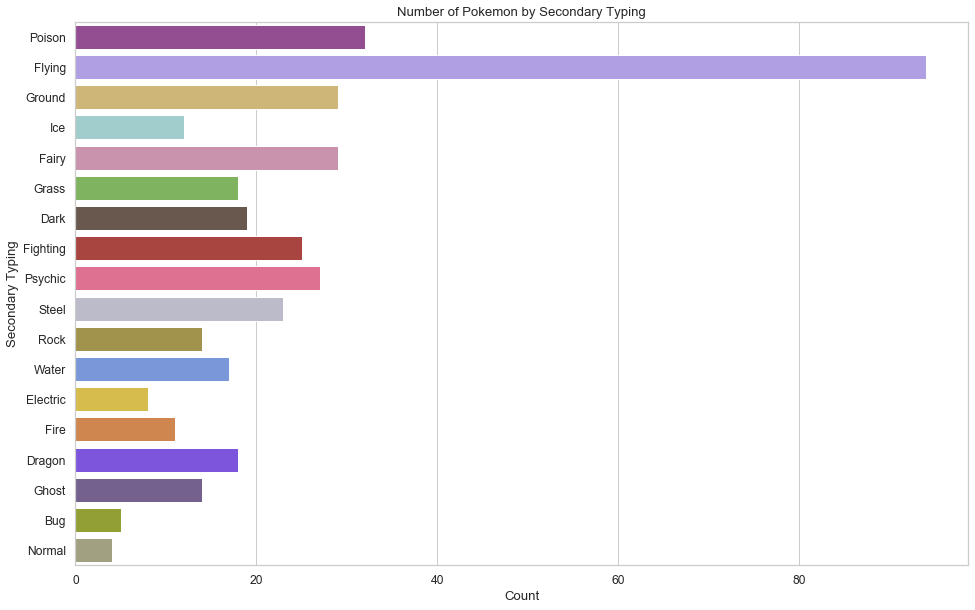

In [322]:
fig, ax = plt.subplots(1,1, figsize = (16,10))
with sns.color_palette(['#A33EA1', '#A98FF3','#E2BF65',
                        '#96D9D6','#D685AD','#7AC74C',
                        '#705746','#C22E28','#F95587',
                        '#B7B7CE','#B6A136','#6390F0',
                        '#F7D02C','#EE8130','#6F35FC',
                        '#735797','#A6B91A','#A8A77A'], desat = 0.9):
    sns.countplot(data = df, y = 'type_2', orient = 'h')
    ax.set(xlabel = 'Count', ylabel = 'Secondary Typing', title = 'Number of Pokemon by Secondary Typing')

#### It seems that flying is the least common primary typing, but the most common secondary typing by a large extent. On the other hand, water is the most common primary typing.

In [42]:
df['type_2'].isna().sum()
df.loc[df['type_2'].isna() == True]

410


,name,classification,type_1,type_2,height_m,weight_kg,capture_rate,abilities,hp,atk,...,taken_psychic,taken_bug,taken_rock,taken_ghost,taken_dragon,taken_dark,taken_steel,taken_fairy,is_legendary,count
id,,,,,,,,,,,,,,,,,,,,,
4,Charmander,Lizard Pokémon,Fire,NaN,0.6,8.5,45,Blaze,39,52,...,1.0,0.5,2.0,1.0,1.0,1.0,0.5,0.5,0,1
5,Charmeleon,Flame Pokémon,Fire,NaN,1.1,19.0,45,Blaze,58,64,...,1.0,0.5,2.0,1.0,1.0,1.0,0.5,0.5,0,1
7,Squirtle,Tiny Turtle Pokémon,Water,NaN,0.5,9.0,45,Torrent,44,48,...,1.0,1.0,1.0,1.0,1.0,1.0,0.5,1.0,0,1
8,Wartortle,Turtle Pokémon,Water,NaN,1.0,22.5,45,Torrent,59,63,...,1.0,1.0,1.0,1.0,1.0,1.0,0.5,1.0,0,1
9,Blastoise,Shellfish Pokémon,Water,NaN,1.6,85.5,45,Torrent,79,83,...,1.0,1.0,1.0,1.0,1.0,1.0,0.5,1.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
800,Necrozma,Prism Pokémon,Psychic,NaN,2.4,230.0,3,Prism Armor,97,107,...,0.5,2.0,1.0,2.0,1.0,2.0,1.0,1.0,1,1
803,Poipole,Poison Pin Pokémon,Poison,NaN,0.6,1.8,3,Beast Boost,67,73,...,2.0,0.5,1.0,1.0,1.0,1.0,1.0,0.5,1,1
807,Zeraora,Thunderclap Pokémon,Electric,NaN,1.5,44.5,3,Volt Absorb,88,112,...,1.0,1.0,1.0,1.0,1.0,1.0,0.5,1.0,1,1


#### There are 410 mono-types and 399 dual-types. 

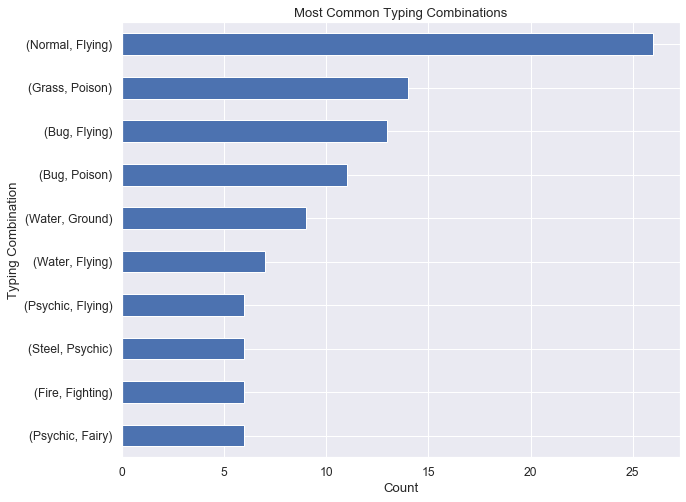

In [50]:
type_combi = df[~df['type_2'].isnull()].groupby(['type_1', 'type_2']).size().sort_values(ascending = True)
ax = type_combi.tail(10).plot(kind = 'barh', figsize = (10,8), title = 'Most Common Typing Combinations', grid = True)
ax.set_xlabel('Count')
ax.set_ylabel('Typing Combination');

#### The most common typing combinations are (Normal, Flying), (Grass, Poison) and (Bug, Flying).

In [11]:
print(df['is_legendary'].sum())
legend_df = df.loc[df['is_legendary'] == 1]
non_legend_df = df.loc[df['is_legendary'] == 0]

81


#### There are 81 legendaries, and 728 non-legendaries.

In [52]:
print(legend_df.groupby('type_1').count()['count'].sort_values(ascending = False))
print(legend_df.groupby('type_2').count()['count'].sort_values(ascending = False))

type_1
Psychic     17
Steel        8
Water        7
Dragon       7
Fire         6
Electric     6
Rock         5
Normal       5
Grass        4
Dark         3
Bug          3
Ground       2
Ice          2
Poison       2
Flying       1
Fighting     1
Fairy        1
Ghost        1
Name: count, dtype: int64
type_2
Flying      10
Fighting     6
Fairy        6
Steel        5
Dragon       5
Psychic      3
Ghost        3
Fire         2
Water        1
Poison       1
Ice          1
Ground       1
Grass        1
Electric     1
Name: count, dtype: int64


#### Among legendaries, psychic is the most common primary typing while flying is the most common secondary typing.

In [53]:
print(non_legend_df.groupby('type_1').count()['count'].sort_values(ascending = False))
print(non_legend_df.groupby('type_2').count()['count'].sort_values(ascending = False))

type_1
Water       107
Normal      100
Grass        74
Bug          69
Fire         47
Rock         41
Psychic      36
Electric     34
Poison       32
Ground       30
Fighting     28
Dark         26
Ghost        26
Ice          21
Dragon       20
Steel        18
Fairy        17
Flying        2
Name: count, dtype: int64
type_2
Flying      84
Poison      31
Ground      28
Psychic     24
Fairy       23
Fighting    19
Dark        19
Steel       18
Grass       17
Water       16
Rock        14
Dragon      13
Ghost       11
Ice         11
Fire         9
Electric     7
Bug          5
Normal       4
Name: count, dtype: int64


#### Among non-legendaries, water is the most common primary typing while flying is the most common secondary typing.

In [58]:
legend_df.describe()

,height_m,weight_kg,capture_rate,hp,atk,def,sp_atk,sp_def,spd,total_stats,...,taken_psychic,taken_bug,taken_rock,taken_ghost,taken_dragon,taken_dark,taken_steel,taken_fairy,is_legendary,count
count,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,...,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.00000,81.000000,81.0,81.0
mean,2.208642,195.903704,16.283951,93.370370,104.320988,98.234568,107.469136,98.493827,91.098765,592.987654,...,0.876543,0.993827,1.169753,1.253086,0.981481,1.228395,0.95679,1.114198,1.0,1.0
std,1.742211,251.891994,41.031767,29.672565,27.823474,30.334086,29.681681,29.368403,26.346539,78.113458,...,0.489137,0.673117,0.724382,0.703222,0.508948,0.684879,0.56980,0.602144,0.0,0.0
min,0.100000,0.100000,3.000000,43.000000,29.000000,31.000000,29.000000,31.000000,13.000000,200.000000,...,0.000000,0.250000,0.250000,0.000000,0.000000,0.500000,0.25000,0.250000,1.0,1.0
25%,1.200000,21.200000,3.000000,79.000000,90.000000,80.000000,90.000000,80.000000,80.000000,570.000000,...,0.500000,0.500000,1.000000,1.000000,1.000000,1.000000,0.50000,1.000000,1.0,1.0
50%,1.800000,100.000000,3.000000,91.000000,100.000000,95.000000,105.000000,98.000000,95.000000,600.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.0,1.0
75%,3.000000,230.000000,3.000000,100.000000,125.000000,115.000000,130.000000,115.000000,108.000000,600.000000,...,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.00000,1.000000,1.0,1.0
max,9.200000,999.900000,255.000000,223.000000,181.000000,211.000000,173.000000,200.000000,151.000000,720.000000,...,2.000000,4.000000,4.000000,4.000000,2.000000,4.000000,4.00000,4.000000,1.0,1.0


In [59]:
non_legend_df.describe()

,height_m,weight_kg,capture_rate,hp,atk,def,sp_atk,sp_def,spd,total_stats,...,taken_psychic,taken_bug,taken_rock,taken_ghost,taken_dragon,taken_dark,taken_steel,taken_fairy,is_legendary,count
count,728.000000,728.000000,728.000000,728.000000,728.000000,728.000000,728.000000,728.000000,728.000000,728.000000,...,728.000000,728.000000,728.000000,728.000000,728.000000,728.000000,728.000000,728.000000,728.0,728.0
mean,1.046566,47.787225,106.791209,66.217033,73.021978,68.865385,65.269231,66.789835,62.917582,403.081044,...,1.021635,0.991071,1.255151,0.958104,0.967033,1.038805,0.983860,1.061126,0.0,1.0
std,0.911014,73.206237,74.100254,24.798326,28.118526,28.270865,26.196885,25.136514,26.439286,97.544391,...,0.496510,0.588101,0.693151,0.531630,0.333191,0.396583,0.490624,0.513109,0.0,0.0
min,0.100000,0.100000,3.000000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000,175.000000,...,0.000000,0.250000,0.250000,0.000000,0.000000,0.250000,0.250000,0.250000,0.0,1.0
25%,0.500000,8.675000,45.000000,50.000000,52.000000,50.000000,45.000000,50.000000,43.000000,316.000000,...,1.000000,0.500000,1.000000,1.000000,1.000000,1.000000,0.500000,1.000000,0.0,1.0
50%,0.900000,24.950000,75.000000,64.500000,70.000000,65.000000,60.000000,65.000000,60.000000,411.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.0
75%,1.325000,55.500000,190.000000,77.250000,90.000000,84.250000,85.000000,80.000000,80.000000,490.000000,...,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.0
max,14.500000,920.000000,255.000000,255.000000,165.000000,230.000000,145.000000,230.000000,160.000000,670.000000,...,4.000000,4.000000,4.000000,2.000000,2.000000,2.000000,4.000000,4.000000,0.0,1.0


#### At first glance, it can be observed that legendaries have a much lower capture rate and much higher total stats on average compared to non-legendaries.

In [54]:
to_plot = df.sort_values(by = 'height_m', ascending = True).tail(10)
fig = px.bar(to_plot, x = 'height_m', y = 'name', orientation = 'h', labels = {'name' : 'Name', 'height_m': 'Height (m)'}, text_auto = True)
fig.update_layout(title= 'Top 10 Tallest Pokemon',
                  yaxis = dict(autorange = True, showgrid = True),
                  paper_bgcolor = 'rgb(255, 255, 255)',
                  plot_bgcolor = 'rgb(243, 243, 243)',
                  showlegend = True)
fig.update_traces(marker_color = 'rgb(153, 153, 255)', marker_line_color = 'rgb(8,100,159)',
                  marker_line_width = 1.5, opacity = 0.6)
fig.show()

In [55]:
to_plot = df.sort_values(by = 'weight_kg', ascending = True).tail(10)
fig = px.bar(to_plot, x = 'weight_kg', y = 'name', orientation = 'h', labels = {'name' : 'Name', 'weight_kg': 'Weight (kg)'}, text_auto = True)
fig.update_layout(title= 'Top 10 Heaviest Pokemon',
                  yaxis = dict(autorange = True, showgrid = True),
                  paper_bgcolor = 'rgb(255, 255, 255)',
                  plot_bgcolor = 'rgb(243, 243, 243)',
                  showlegend = True)
fig.update_traces(marker_color = 'rgb(153, 153, 255)', marker_line_color = 'rgb(8,100,159)',
                  marker_line_width = 1.5, opacity = 0.6)
fig.show()

In [56]:
to_plot = df.sort_values(by = 'hp', ascending = True).tail(10)
fig = px.bar(to_plot, x = 'hp', y = 'name', orientation = 'h', labels = {'name' : 'Name', 'hp': 'HP'}, text_auto = True)
fig.update_layout(title= 'Top 10 Pokemon with the Highest HP Stat',
                  yaxis = dict(autorange = True, showgrid = True),
                  paper_bgcolor = 'rgb(255, 255, 255)',
                  plot_bgcolor = 'rgb(243, 243, 243)',
                  showlegend = True)
fig.update_traces(marker_color = 'rgb(158, 255, 225)', marker_line_color = 'rgb(8,100,159)',
                  marker_line_width = 1.5, opacity = 0.6)
fig.show()

In [57]:
to_plot = df.sort_values(by = 'atk', ascending = True).tail(10)
fig = px.bar(to_plot, x = 'atk', y = 'name', orientation = 'h', labels = {'name' : 'Name', 'atk': 'Attack'}, text_auto = True)
fig.update_layout(title= 'Top 10 Pokemon with the Highest Attack Stat',
                  yaxis = dict(autorange = True, showgrid = True),
                  paper_bgcolor = 'rgb(255, 255, 255)',
                  plot_bgcolor = 'rgb(243, 243, 243)',
                  showlegend = True)
fig.update_traces(marker_color = 'rgb(255, 228, 225)', marker_line_color = 'rgb(8,100,159)',
                  marker_line_width = 1.5, opacity = 0.6)
fig.show()

In [58]:
to_plot = df.sort_values(by = 'def', ascending = True).tail(10)
fig = px.bar(to_plot, x = 'def', y = 'name', orientation = 'h', labels = {'name' : 'Name', 'def': 'Defense'}, text_auto = True)
fig.update_layout(title= 'Top 10 Pokemon with the Highest Defense Stat',
                  yaxis = dict(autorange = True, showgrid = True),
                  paper_bgcolor = 'rgb(255, 255, 255)',
                  plot_bgcolor = 'rgb(243, 243, 243)',
                  showlegend = True)
fig.update_traces(marker_color = 'rgb(210, 105, 30)', marker_line_color = 'rgb(8,100,159)',
                  marker_line_width = 1.5, opacity = 0.6)
fig.show()

In [114]:
to_plot = df.sort_values(by = 'sp_atk', ascending = True).tail(10)
fig = px.bar(to_plot, x = 'sp_atk', y = 'name', orientation = 'h', labels = {'name' : 'Name', 'sp_atk': 'Sp. Attack'}, text_auto = True)
fig.update_layout(title= 'Top 10 Pokemon with the Highest Sp. Attack Stat',
                  yaxis = dict(autorange = True, showgrid = True),
                  paper_bgcolor = 'rgb(255, 255, 255)',
                  plot_bgcolor = 'rgb(243, 243, 243)',
                  showlegend = True)
fig.update_traces(marker_color = 'rgb(250, 128, 114)', marker_line_color = 'rgb(8,100,159)',
                  marker_line_width = 1.5, opacity = 0.6)
fig.show()

In [115]:
to_plot = df.sort_values(by = 'sp_def', ascending = True).tail(10)
fig = px.bar(to_plot, x = 'sp_def', y = 'name', orientation = 'h', labels = {'name' : 'Name', 'sp_def': 'Sp. Defense'}, text_auto = True)
fig.update_layout(title= 'Top 10 Pokemon with the Highest Sp. Defense Stat',
                  yaxis = dict(autorange = True, showgrid = True),
                  paper_bgcolor = 'rgb(255, 255, 255)',
                  plot_bgcolor = 'rgb(243, 243, 243)',
                  showlegend = True)
fig.update_traces(marker_color = 'rgb(218, 165, 32)', marker_line_color = 'rgb(8,100,159)',
                  marker_line_width = 1.5, opacity = 0.6)
fig.show()

In [116]:
to_plot = df.sort_values(by = 'spd', ascending = True).tail(10)
fig = px.bar(to_plot, x = 'spd', y = 'name', orientation = 'h', labels = {'name' : 'Name', 'spd': 'Speed'}, text_auto = True)
fig.update_layout(title= 'Top 10 Pokemon with the Highest Speed Stat',
                  yaxis = dict(autorange = True, showgrid = True),
                  paper_bgcolor = 'rgb(255, 255, 255)',
                  plot_bgcolor = 'rgb(243, 243, 243)',
                  showlegend = True)
fig.update_traces(marker_color = 'rgb(255, 250, 205)', marker_line_color = 'rgb(8,100,159)',
                  marker_line_width = 1.5, opacity = 0.6)
fig.show()

In [117]:
to_plot = df.sort_values(by = 'total_stats', ascending = True).tail(10)
fig = px.bar(to_plot, x = 'total_stats', y = 'name', orientation = 'h', labels = {'name' : 'Name', 'total_stats': 'HP'}, text_auto = True)
fig.update_layout(title= 'Top 10 Pokemon with the Highest Total Stats',
                  yaxis = dict(autorange = True, showgrid = True),
                  paper_bgcolor = 'rgb(255, 255, 255)',
                  plot_bgcolor = 'rgb(243, 243, 243)',
                  showlegend = True)
fig.update_traces(marker_color = 'rgb(255, 0, 255)', marker_line_color = 'rgb(8,100,159)',
                  marker_line_width = 1.5, opacity = 0.6)
fig.show()

## Bivariate Analysis (Typing and Legendary Status)

In [327]:
groups = df.groupby('type_1').aggregate(np.mean)

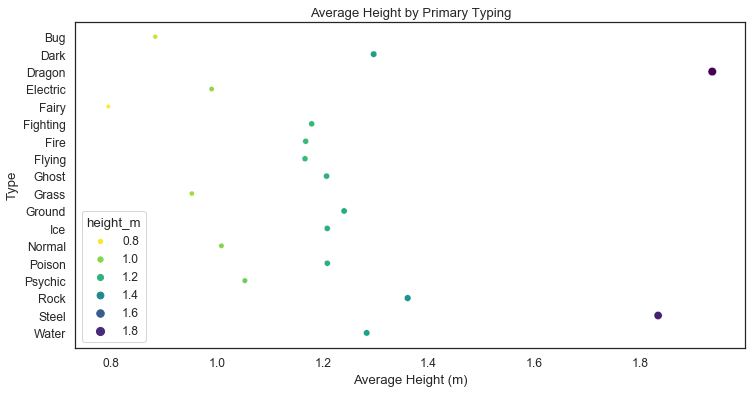

In [331]:
sns.set_style('white')
fig , ax = plt.subplots(1,1,figsize=(12,6))
sns.scatterplot(x = groups.height_m, y = groups.index, hue = groups.height_m, size = groups.height_m, palette = 'viridis_r')
plt.xlabel('Average Height (m)')
plt.ylabel('Type')
plt.title('Average Height by Primary Typing');

#### Dragon and Steel types have the highest average heights, while fairy types have the lowest average height.

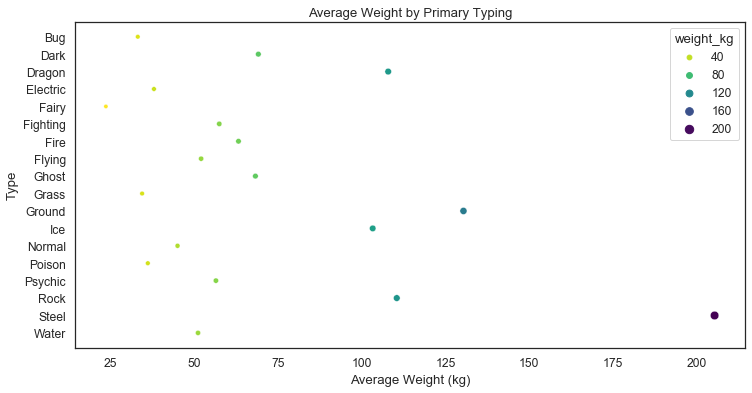

In [332]:
sns.set_style('white')
fig , ax = plt.subplots(1,1,figsize=(12,6))
sns.scatterplot(x = groups.weight_kg, y = groups.index, hue = groups.weight_kg, size = groups.weight_kg, palette = 'viridis_r')
plt.xlabel('Average Weight (kg)')
plt.ylabel('Type')
plt.title('Average Weight by Primary Typing');

#### Steel types have the highest average weight, while fairy types have the lowest average weight.

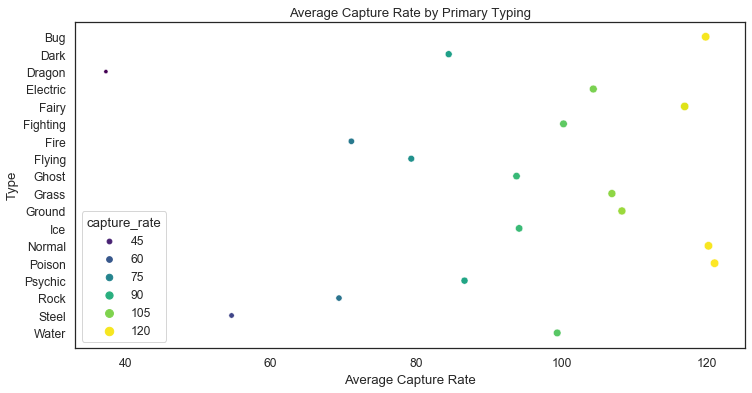

In [333]:
sns.set_style('white')
fig , ax = plt.subplots(1,1,figsize=(12,6))
sns.scatterplot(x = groups.capture_rate, y = groups.index, hue = groups.capture_rate,
                size = groups.capture_rate, palette = 'viridis')
plt.xlabel('Average Capture Rate')
plt.ylabel('Type')
plt.title('Average Capture Rate by Primary Typing');

#### Dragon types have the lowest average capture rate.

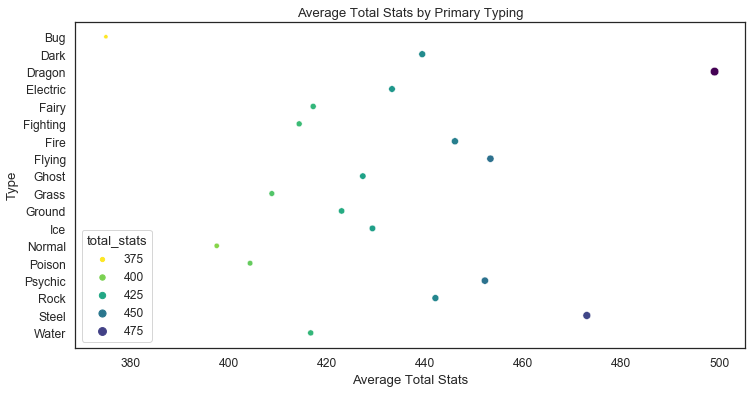

In [334]:
sns.set_style('white')
fig , ax = plt.subplots(1,1,figsize=(12,6))
sns.scatterplot(x = groups.total_stats, y = groups.index, hue = groups.total_stats,
                size = groups.total_stats, palette = 'viridis_r')
plt.xlabel('Average Total Stats')
plt.ylabel('Type')
plt.title('Average Total Stats by Primary Typing');

#### Dragon types have the highest average total stats, while bug types have the lowest.

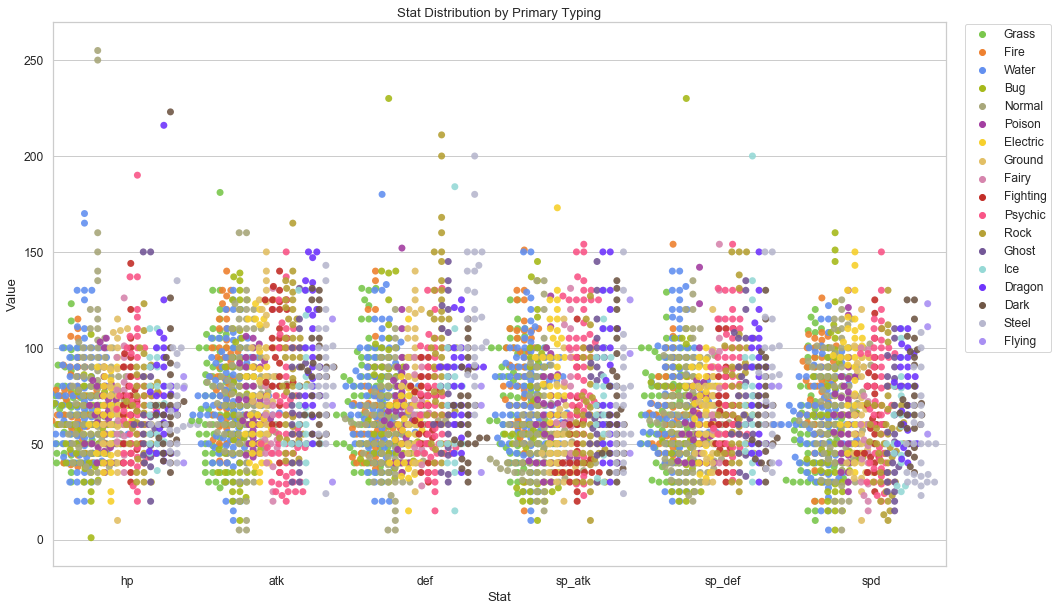

In [7]:
cols = ['name', 'type_1', 'type_2', 'hp', 'atk', 'def','sp_atk', 'sp_def', 'spd']
to_plot = pd.melt(df[cols], id_vars = ['name', 'type_1', 'type_2'], var_name = 'stat')

sns.set_theme(font_scale = 1.1, style = 'whitegrid')
fig , ax = plt.subplots(1,1,figsize=(16,10))
with sns.color_palette(['#7AC74C', '#EE8130','#6390F0',
                        '#A6B91A','#A8A77A','#A33EA1',
                        '#F7D02C','#E2BF65','#D685AD',
                        '#C22E28','#F95587','#B6A136',
                        '#735797','#96D9D6','#6F35FC',
                        '#705746','#B7B7CE','#A98FF3']):
    sns.swarmplot(data = to_plot, x = 'stat', y = 'value', hue = 'type_1', dodge = True, size = 7, alpha = 0.9)
    ax.set(xlabel = 'Stat', ylabel = 'Value', title = 'Stat Distribution by Primary Typing')
    plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad= 0.1);

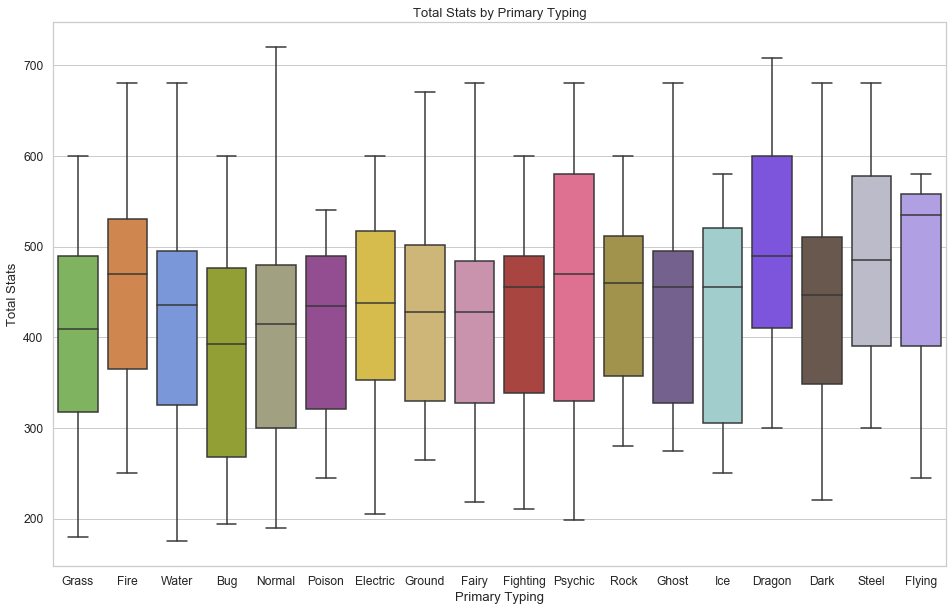

In [59]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(1,1, figsize = (16,10))
with sns.color_palette(['#7AC74C', '#EE8130','#6390F0',
                        '#A6B91A','#A8A77A','#A33EA1',
                        '#F7D02C','#E2BF65','#D685AD',
                        '#C22E28','#F95587','#B6A136',
                        '#735797','#96D9D6','#6F35FC',
                        '#705746','#B7B7CE','#A98FF3'], desat = 0.9):
    sns.boxplot(x = df.type_1, y = df.total_stats)
    ax.set(xlabel = 'Primary Typing', ylabel = 'Total Stats', title = 'Total Stats by Primary Typing')

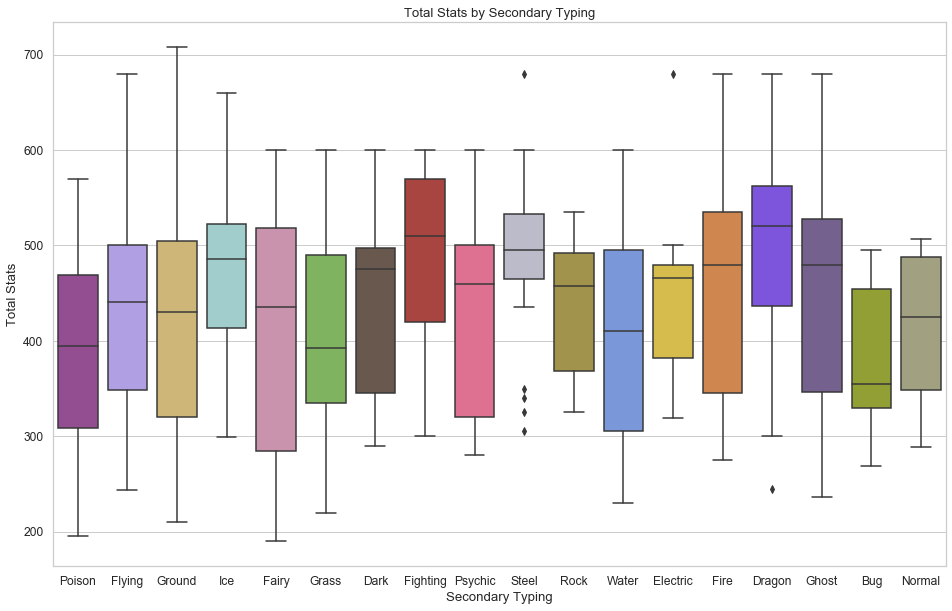

In [60]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(1,1, figsize = (16,10))
with sns.color_palette(['#A33EA1', '#A98FF3','#E2BF65',
                        '#96D9D6','#D685AD','#7AC74C',
                        '#705746','#C22E28','#F95587',
                        '#B7B7CE','#B6A136','#6390F0',
                        '#F7D02C','#EE8130','#6F35FC',
                        '#735797','#A6B91A','#A8A77A'], desat = 0.9):
    sns.boxplot(x = df.type_2, y = df.total_stats)
    ax.set(xlabel = 'Secondary Typing', ylabel = 'Total Stats', title = 'Total Stats by Secondary Typing')

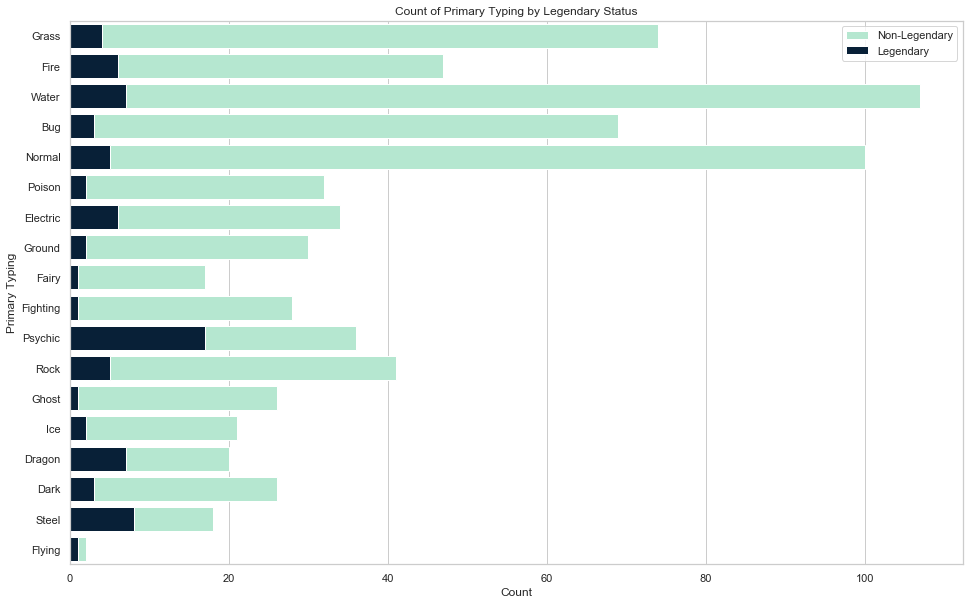

In [82]:
sns.set_theme(style = "whitegrid")
fig, ax = plt.subplots(1,1, figsize = (16,10))
with sns.color_palette(['#ADEFD1FF', '#00203FFF']):
    sns.countplot(data = df, y = 'type_1', hue = 'is_legendary', dodge = False)
    ax.set(xlabel = 'Count', ylabel = 'Primary Typing', title = 'Count of Primary Typing by Legendary Status')
    plt.legend(labels = ['Non-Legendary', 'Legendary'])

#### Psychic, Steel and Dragon primary typings have the highest probability to be legendary.

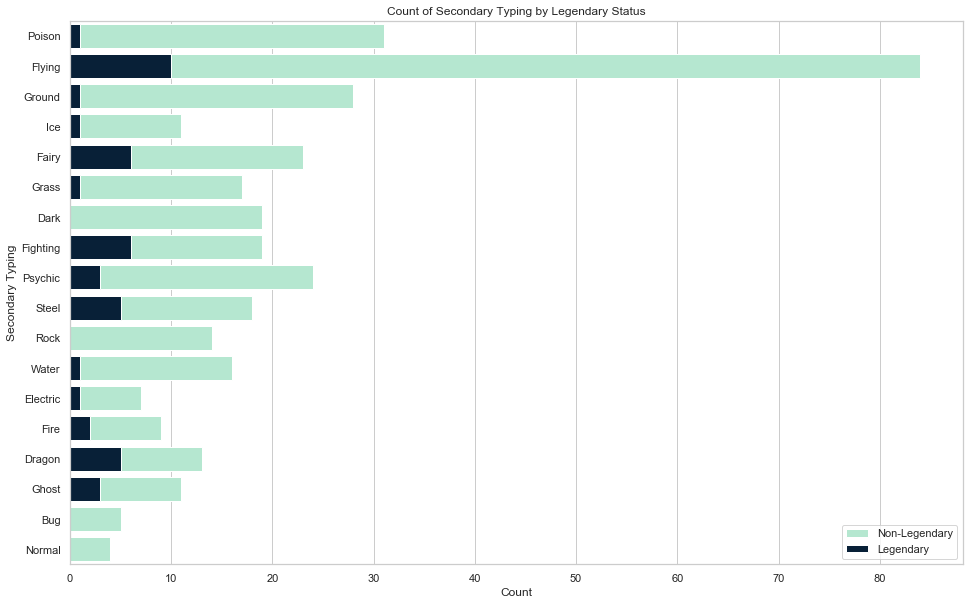

In [92]:
sns.set_theme(style = "whitegrid")
fig, ax = plt.subplots(1,1, figsize = (16,10))
with sns.color_palette(['#ADEFD1FF', '#00203FFF']):
    sns.countplot(data = df, y = 'type_2', hue = 'is_legendary', dodge = False)
    ax.set(xlabel = 'Count', ylabel = 'Secondary Typing', title = 'Count of Secondary Typing by Legendary Status')
    plt.legend(labels = ['Non-Legendary', 'Legendary'])

#### No clear trend can be observed, but it seems that there are no legendaries with dark, rock, bug and normal secondary typings.

In [110]:
print('Mono type:' ,legend_df.loc[legend_df['type_2'].isna()].count()['count'])
print('Dual-type:' ,legend_df.loc[~legend_df['type_2'].isna()].count()['count'])

Mono type: 35
Dual-type: 46


#### There are 35 mono-type and 46 dual-type legendaries.

In [101]:
fig = make_subplots(rows = 1, cols = 2)
trace0 = go.Box(y = legend_df.capture_rate, name = 'Legendary', marker_color='#EB89B5', boxpoints = 'all', opacity = 0.75)
trace1 = go.Box(y = non_legend_df.capture_rate, name = 'Non-legendary', marker_color='#330C73', boxpoints = 'all', opacity = 0.75)
fig.add_trace(trace0, 1, 1)
fig.add_trace(trace1, 1, 2)
fig.update_layout(title = 'Distribution of Capture Rate for Legendary vs Non-legendary Pokemon',
                  yaxis = dict(autorange = True, showgrid = True),
                  paper_bgcolor = 'rgb(255, 255, 255)',
                  plot_bgcolor = 'rgb(243, 243, 243)',
                  showlegend = True)
fig.show()

#### Legendaries have a significantly lower capture rate, with most possessing a capture rate of only 3, compared to non-legendaries.

In [99]:
fig = make_subplots(rows = 1, cols = 2)
trace0 = go.Box(y = legend_df.height_m, name = 'Legendary', marker_color='#EB89B5', boxpoints = 'all', opacity = 0.75)
trace1 = go.Box(y = non_legend_df.height_m, name = 'Non-legendary', marker_color='#330C73', boxpoints = 'all', opacity = 0.75)
fig.add_trace(trace0, 1, 1)
fig.add_trace(trace1, 1, 2)
fig.update_layout(title = 'Distribution of Height (m) for Legendary vs Non-legendary Pokemon',
                  yaxis = dict(autorange = True, showgrid = True),
                  paper_bgcolor = 'rgb(255, 255, 255)',
                  plot_bgcolor = 'rgb(243, 243, 243)',
                  showlegend = True)
fig.show()

#### It seems that legendaries tend to be taller than non-legendaries.

In [98]:
fig = make_subplots(rows = 1, cols = 2)
trace0 = go.Box(y = legend_df.weight_kg, name = 'Legendary', marker_color='#EB89B5', boxpoints = 'all', opacity = 0.75)
trace1 = go.Box(y = non_legend_df.weight_kg, name = 'Non-legendary', marker_color='#330C73', boxpoints = 'all', opacity = 0.75)
fig.add_trace(trace0, 1, 1)
fig.add_trace(trace1, 1, 2)
fig.update_layout(title = 'Distribution of Weight (kg) for Legendary vs Non-legendary Pokemon',
                  yaxis = dict(autorange = True, showgrid = True),
                  paper_bgcolor = 'rgb(255, 255, 255)',
                  plot_bgcolor = 'rgb(243, 243, 243)',
                  showlegend = True)
fig.show()

#### It seems that legendaries tend to be heavier than non-legendaries.

In [100]:
fig = make_subplots(rows = 1, cols = 2)
trace0 = go.Box(y = legend_df.total_stats, name = 'Legendary', marker_color='#EB89B5', boxpoints = 'all', opacity = 0.75)
trace1 = go.Box(y = non_legend_df.total_stats, name = 'Non-legendary', marker_color='#330C73', boxpoints = 'all', opacity = 0.75)
fig.add_trace(trace0, 1, 1)
fig.add_trace(trace1, 1, 2)
fig.update_layout(title = 'Distribution of Total Stat for Legendary vs Non-legendary Pokemon',
                  yaxis = dict(autorange = True, showgrid = True),
                  paper_bgcolor = 'rgb(255, 255, 255)',
                  plot_bgcolor = 'rgb(243, 243, 243)',
                  showlegend = True)
fig.show()

#### It seems that legendaries tend to possess much greater total stats than non-legendaries.

## Building a Binary Classifier to predict whether a given Pokemon is Legendary (Positive: 1) or Non-legendary (Negative: 0)

From our analysis conducted prior, we know that psychic and steel primary typings have the highest probability of being legendary. Similarly, we know that legendaries tend to be heavier, taller and possess much greater total stats. Furthermore, legendaries have a significantly lower capture rate, where most possess a capture rate of only 3.

In [2]:
# df = pd.read_csv('all_pokemon_data_modified.csv')

As many legendaries are mono-type, we can remove secondary typing from our list of predictor variables. Furthermore, we can consider adding additional columns to signify whether a given Pokemon possess a psychic, steel or dragon primary typing.

In [137]:
df['is_psychic'] = 0
df['is_steel'] = 0
df['is_dragon'] = 0

for i in range(len(df)):
    if df.loc[i, 'type_1'] == 'Psychic':
        df.loc[i, 'is_psychic'] = 1
        
    elif df.loc[i, 'type_1'] == 'Steel':
        df.loc[i, 'is_steel'] = 1
        
    elif df.loc[i, 'type_1'] == 'Dragon':
        df.loc[i, 'is_dragon'] = 1

In [141]:
predictor_cols = ['height_m', 'weight_kg', 'capture_rate', 'hp', 'atk', 'def', 'sp_atk',
       'sp_def', 'spd', 'total_stats', 'is_psychic', 'is_steel', 'is_dragon']

In [173]:
X = df[predictor_cols]
y = df['is_legendary']

In [174]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, shuffle = True)

In [175]:
print('Positive:', y_train.sum())
print('Negative:', y_train.count() - y_train.sum())

Positive: 58
Negative: 508


We have 58 positive cases and 508 negative cases in our training data.

In [176]:
print('Positive:', y_test.sum())
print('Negative:', y_test.count() - y_test.sum())

Positive: 23
Negative: 220


We have 23 positive cases and 220 negative cases in our test data.

In [177]:
# Apply SMOTE
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_smote_train, y_smote_train = smote.fit_resample(X_train, y_train)

In [178]:
print('Old Positive:', y_train.sum())
print('Old Negative:', y_train.count() - y_train.sum())

print('New Positive:', y_smote_train.sum())
print('New Negative:', y_smote_train.count() - y_smote_train.sum())

Old Positive: 58
Old Negative: 508
New Positive: 508
New Negative: 508


We now have a training set that is much more balanced.

In [181]:
# Apply scaler to standardize numerical columns

scaler = StandardScaler()
scaler.fit(X_smote_train[predictor_cols[:-3]])

X_smote_train[predictor_cols[:-3]] = scaler.transform(X_smote_train[predictor_cols[:-3]])
X_test[predictor_cols[:-3]] = scaler.transform(X_test[predictor_cols[:-3]])

In [195]:
X_smote_train = X_smote_train.astype({'is_psychic': 'category', 'is_steel': 'category', 'is_dragon': 'category'})
X_test = X_test.astype({'is_psychic': 'category', 'is_steel': 'category', 'is_dragon': 'category'})

y_smote_train = y_smote_train.astype('category')
y_test = y_test.astype('category')

#### Fitting a logistic regression model to the data:

In [196]:
param_grid = {'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1.0, 10.0]}

In [200]:
grid_log_reg = GridSearchCV(LogisticRegression(), param_grid, 
                            cv = 3, 
                            verbose = 3,
                            n_jobs = -1,
                            scoring = 'balanced_accuracy')

grid_log_reg.fit(X_smote_train, y_smote_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning:


15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    % (solver, penalty)
ValueError: Solver lbfgs supports only 'l2' or 'n

GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1.0, 10.0],
                         'penalty': ['l1', 'l2']},
             scoring='balanced_accuracy', verbose=3)

In [202]:
optimized_log_reg = grid_log_reg.best_estimator_

In [205]:
y_pred_log_reg = optimized_log_reg.predict(X_test)

C:\anaconda3\lib\site-packages\sklearn\base.py:566: FutureWarning:

Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.



[[208   2]
 [ 12  21]]
Test Set Accuracy: 0.9423868312757202
Test Set Balanced Accuracy: 0.8134199134199134
Test Set Precision: 0.9130434782608695
Test Set Recall: 0.6363636363636364
Test Set F1 Score: 0.75
Test Set ROC Score: 0.8134199134199134


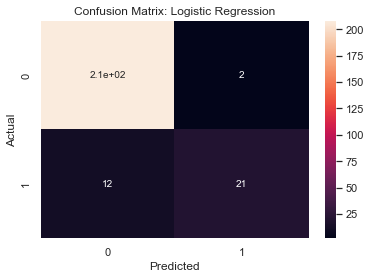

In [259]:
cm = confusion_matrix(y_pred_log_reg, y_test)
print(cm)
ax = plt.subplot()
sns.heatmap(cm, annot = True)

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix: Logistic Regression')

print('Test Set Accuracy:', accuracy_score(y_pred_log_reg, y_test))
print('Test Set Balanced Accuracy:', balanced_accuracy_score(y_pred_log_reg, y_test))
print('Test Set Precision:', precision_score(y_pred_log_reg, y_test))
print('Test Set Recall:', recall_score(y_pred_log_reg, y_test))
print('Test Set F1 Score:', f1_score(y_pred_log_reg, y_test))
print('Test Set ROC Score:', roc_auc_score(y_pred_log_reg, y_test))

logreg_acc = accuracy_score(y_pred_log_reg, y_test)
logreg_balacc = balanced_accuracy_score(y_pred_log_reg, y_test)
logreg_prc = precision_score(y_pred_log_reg, y_test)
logreg_recall = recall_score(y_pred_log_reg, y_test)
logreg_f1 = f1_score(y_pred_log_reg, y_test)
logreg_roc = roc_auc_score(y_pred_log_reg, y_test)

#### Fitting a Random Forest Classifier to the training data:

In [224]:
param_grid = {'n_estimators': np.arange(50, 225, 25), 'max_depth': [3,5,6,7]}

In [225]:
grid_rf = GridSearchCV(RandomForestClassifier(), param_grid, cv = 3, verbose = 3, n_jobs = -1, scoring = 'balanced_accuracy')

grid_rf.fit(X_smote_train, y_smote_train)

Fitting 3 folds for each of 28 candidates, totalling 84 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 6, 7],
                         'n_estimators': array([ 50,  75, 100, 125, 150, 175, 200])},
             scoring='balanced_accuracy', verbose=3)

In [227]:
optimized_rf = grid_rf.best_estimator_

In [228]:
y_pred_rf = optimized_rf.predict(X_test)

[[215   2]
 [  5  21]]
Test Set Accuracy: 0.9711934156378601
Test Set Balanced Accuracy: 0.8992378589152783
Test Set Precision: 0.9130434782608695
Test Set Recall: 0.8076923076923077
Test Set F1 Score: 0.8571428571428572
Test Set ROC Score: 0.8992378589152783


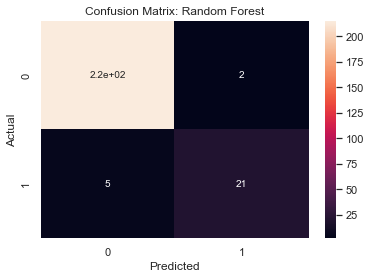

In [260]:
cm = confusion_matrix(y_pred_rf, y_test)
print(cm)
ax = plt.subplot()
sns.heatmap(cm, annot = True)

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix: Random Forest')

print('Test Set Accuracy:', accuracy_score(y_pred_rf, y_test))
print('Test Set Balanced Accuracy:', balanced_accuracy_score(y_pred_rf, y_test))
print('Test Set Precision:', precision_score(y_pred_rf, y_test))
print('Test Set Recall:', recall_score(y_pred_rf, y_test))
print('Test Set F1 Score:', f1_score(y_pred_rf, y_test))
print('Test Set ROC Score:', roc_auc_score(y_pred_rf, y_test))

rf_acc = accuracy_score(y_pred_rf, y_test)
rf_balacc = balanced_accuracy_score(y_pred_rf, y_test)
rf_prc = precision_score(y_pred_rf, y_test)
rf_recall = recall_score(y_pred_rf, y_test)
rf_f1 = f1_score(y_pred_rf, y_test)
rf_roc = roc_auc_score(y_pred_rf, y_test)

Text(0.5, 1.0, 'Feature Importance')

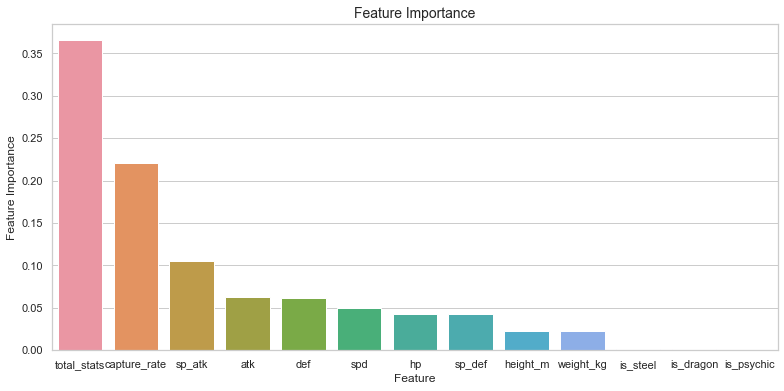

In [246]:
feature_imp = pd.DataFrame({'Feature': predictor_cols, 'Feature Importance': optimized_rf.feature_importances_})
feature_imp.sort_values(by = 'Feature Importance', ascending = False, inplace = True)
fig, ax = plt.subplots(1,1, figsize = (13, 6))
sns.barplot(data = feature_imp, x = 'Feature', y = 'Feature Importance')
plt.title('Feature Importance', fontsize = 14)

#### We can see that our 2 most important features are total_stats and capture_rate.

#### Fitting XGBoost to data:

In [248]:
X_smote_train = X_smote_train.astype({'is_psychic': 'bool', 'is_steel': 'bool', 'is_dragon': 'bool'})
X_test = X_test.astype({'is_psychic': 'bool', 'is_steel': 'bool', 'is_dragon': 'bool'})
dtrain = xgb.DMatrix(X_smote_train, label = y_smote_train)
dtest = xgb.DMatrix(X_test)

In [252]:
params = {'objective': 'binary:logistic', 'eval_metric': 'auc'} # Use default values for everything else
num_round = 100
xgb_model = xgb.train(params, dtrain, num_round)

In [253]:
y_pred_xgb = xgb_model.predict(dtest)

In [255]:
y_pred_class_xgb = []
for i in range(len(y_pred_xgb)):
    if y_pred_xgb[i] >= 0.5: # Threshold of 0.5
        y_pred_class_xgb.append(1) # Predicted Positive
    else:
        y_pred_class_xgb.append(0) # Predicted Negative

[[216   1]
 [  4  22]]
Test Set Accuracy: 0.9794238683127572
Test Set Balanced Accuracy: 0.9207727756114853
Test Set Precision: 0.9565217391304348
Test Set Recall: 0.8461538461538461
Test Set F1 Score: 0.8979591836734695
Test Set ROC Score: 0.9207727756114853


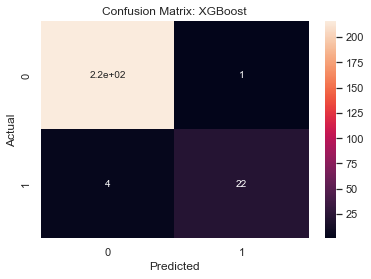

In [261]:
cm = confusion_matrix(y_pred_class_xgb, y_test)
print(cm)
ax = plt.subplot()
sns.heatmap(cm, annot = True)

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix: XGBoost')

print('Test Set Accuracy:', accuracy_score(y_pred_class_xgb, y_test))
print('Test Set Balanced Accuracy:', balanced_accuracy_score(y_pred_class_xgb, y_test))
print('Test Set Precision:', precision_score(y_pred_class_xgb, y_test))
print('Test Set Recall:', recall_score(y_pred_class_xgb, y_test))
print('Test Set F1 Score:', f1_score(y_pred_class_xgb, y_test))
print('Test Set ROC Score:', roc_auc_score(y_pred_class_xgb, y_test))

xgb_acc = accuracy_score(y_pred_class_xgb, y_test)
xgb_balacc = balanced_accuracy_score(y_pred_class_xgb, y_test)
xgb_prc = precision_score(y_pred_class_xgb, y_test)
xgb_recall = recall_score(y_pred_class_xgb, y_test)
xgb_f1 = f1_score(y_pred_class_xgb, y_test)
xgb_roc = roc_auc_score(y_pred_class_xgb, y_test)

## Model Evaluation

In [262]:
clfs = ['Logistic Regression', 'Random Forest', 'XGBoost']
test_acc = [logreg_acc, rf_acc, xgb_acc]
test_balacc = [logreg_balacc, rf_balacc, xgb_balacc]
test_prc = [logreg_prc, rf_prc, xgb_prc]
test_recall = [logreg_recall, rf_recall, xgb_recall]
test_f1 = [logreg_f1, rf_f1, xgb_f1]
test_roc = [logreg_roc, rf_roc, xgb_roc]

,Classifiers,Accuracy,Balanced-Accuracy,Precision,Recall,F1-score,ROC-Score
0,Logistic Regression,0.942387,0.813420,0.913043,0.636364,0.750000,0.813420
1,Random Forest,0.971193,0.899238,0.913043,0.807692,0.857143,0.899238
2,XGBoost,0.979424,0.920773,0.956522,0.846154,0.897959,0.920773


In [266]:
pd.DataFrame({'Classifiers': clfs, 'Accuracy': test_acc, 'Balanced-Accuracy': test_balacc,
             'Precision': test_prc, 'Recall': test_recall, 'F1-score': test_f1, 'ROC-Score': test_roc})

,Classifiers,Accuracy,Balanced-Accuracy,Precision,Recall,F1-score,ROC-Score
0,Logistic Regression,0.942387,0.813420,0.913043,0.636364,0.750000,0.813420
1,Random Forest,0.971193,0.899238,0.913043,0.807692,0.857143,0.899238
2,XGBoost,0.979424,0.920773,0.956522,0.846154,0.897959,0.920773


#### Overall, our XGBoost model performs the best on the given dataset, with the highest balanced-accuracy, F1-Score and ROC Score.